In [1]:
import os, shutil
# point to the Program Files Graphviz dot.exe you validated
os.environ['GRAPHVIZ_DOT'] = r"C:\Program Files\Graphviz\bin\dot.exe"

# Optional: ensure the process PATH prefers the same Graphviz bin directory
gv_bin = r"C:\Program Files\Graphviz\bin"
os.environ['PATH'] = gv_bin + os.pathsep + os.environ.get('PATH', '')

# Sanity checks
print("GRAPHVIZ_DOT:", os.environ.get('GRAPHVIZ_DOT'))
print("shutil.which('dot') ->", shutil.which('dot'))

GRAPHVIZ_DOT: C:\Program Files\Graphviz\bin\dot.exe
shutil.which('dot') -> C:\Program Files\Graphviz\bin\dot.EXE


In [2]:
import pymc as pm 
import arviz as az 
import pandas as pd 
import numpy as np
import pytensor.tensor as pt
import graphviz

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [3]:
df = pd.read_csv('../data/processed/vax_pop_merged.csv')
df.columns

Index(['fips', 'county_x', 'state_x', 'mmr_coverage', 'year', 'count',
       'had_cases', 'state_fips', 'county_fips', 'state_y', 'county_y',
       'population', 'pop_under5', 'pop_5to13', 'pop_14to17', 'pop_18to24',
       'pop_25to44', 'pop_45to64', 'pop_65plus', 'area_sqkm', 'area_sqmi',
       'pop_density'],
      dtype='object')

Derive IDs and z-scored covariates: 

In [4]:
df['state_id'] = df['state_x'].astype('category').cat.codes
df['year'] = df['year'].astype('category').cat.codes 

age_cols = [c for c in df.columns if c.startswith('pop_')]

def zscore(x): 
    mu, sd = np.nanmean(x), np.nanstd(x)
    if sd == 0 or np.isnan(sd):
        return np.zeros_like(x, dtype=float)
    return (x - mu) / sd

# For pop density, log1p then z-score
df['log_pop_density'] = zscore(np.log1p(df['pop_density']))
for col in age_cols:
    df[f'z_{col}'] = zscore(df[col])

# Final list of covariates
X_cols = ['log_pop_density'] + [f'z_{c}' for c in age_cols]
X_cols

['log_pop_density',
 'z_pop_under5',
 'z_pop_5to13',
 'z_pop_14to17',
 'z_pop_18to24',
 'z_pop_25to44',
 'z_pop_45to64',
 'z_pop_65plus',
 'z_pop_density']

Build model arrays: 

In [5]:
# Core arrays
state_idx = df['state_id'].to_numpy()
year_idx = df['year'].to_numpy()
pop = df['population'].to_numpy(dtype=float)
mmr = df['mmr_coverage'].to_numpy(dtype=float)
y_obs = df['count'].to_numpy(dtype=int)

# Covariate matrix
X = df[X_cols].to_numpy(dtype=float) 

S = df['state_id'].nunique()
T = df['year'].nunique()

states = df['state_x'].astype('category').cat.categories.tolist()
years = sorted(df['year'].unique().tolist())

# Epidemiological constants
VE = 0.97           # Vaccine efficacy
gamma = 1.0/7.0     # Recovery rate (1/duration of infectiousness)
eps = 1e-6          # Small constant to avoid log(0)  

len(y_obs), S, T, X.shape

(17337, 39, 8, (17337, 9))

Specify the PyMC model (transmission --> $R_0$ --> $p_c$)

In [6]:
with pm.Model() as bhm: 
    # Hierarchy on baseline transmission at zero vaccination
    mu_log_beta0 = pm.Normal('mu_log_beta0', mu=0.0, sigma=1.0)
    sd_log_beta0 = pm.HalfNormal('sd_log_beta0', sigma=0.75)
    log_beta0_state = pm.Normal('log_beta0_state', mu=mu_log_beta0, sigma=sd_log_beta0, shape=S)
    beta0_state = pm.Deterministic('beta0_state', pt.exp(log_beta0_state))

    # Derived R0 per state and overall
    R0_state = pm.Deterministic('R0_state', beta0_state / gamma)
    pc_state = pm.Deterministic('pc_state', 1.0 - (1.0 / R0_state))
    R0_overall = pm.Deterministic('R0_overall', pt.exp(mu_log_beta0) / gamma)
    pc_overall = pm.Deterministic('pc_overall', 1.0 - (1.0 / R0_overall)) 

    # Random intercepts (state + year)
    mu_alpha = pm.Normal('mu_alpha', mu=0.0, sigma=2.0)
    sd_alpha = pm.HalfNormal('sd_alpha', sigma=1.0)
    alpha_state = pm.Normal('alpha_state', mu=mu_alpha, sigma=sd_alpha, shape=S)
    sd_year = pm.HalfNormal('sd_year', sigma=1.0)
    delta_year = pm.Normal('delta_year', mu=0.0, sigma=sd_year, shape=T)

    # Additive covariates
    beta = pm.Normal('beta', mu=0.0, sigma=1.0, shape=X.shape[1])

    # Effective transmission and Re per row 
    susceptible_frac = 1.0 - (VE * mmr)
    beta_eff = beta0_state[state_idx] * susceptible_frac
    Re = pm.Deterministic('Re', beta_eff / gamma)
    log_Re = pt.log(Re) 

    # Strength of Re --> incidence (center near 1)
    kappa = pm.Normal('kappa', mu=1.0, sigma=0.5)

    # Linear predictor (rate model): log(mu) = log(pop) + linpred 
    linpred = alpha_state[state_idx] + delta_year[year_idx] + kappa * log_Re + (X @ beta)
    mu = pt.exp(pt.log(pop) + linpred)

    # Negative binomial likelihood 
    phi = pm.Gamma('phi', alpha=2.0, beta=0.1)
    y = pm.NegativeBinomial('y', mu=mu, alpha=phi, observed=y_obs)

In [7]:
import pymc as pm
# rebuild or reopen your model object `bhm` if needed, then:
gv = pm.model_to_graphviz(bhm)
print(type(gv))
print(gv.source[:800])
png = gv.pipe(format='png')
print("Rendered bytes:", len(png))

<class 'graphviz.graphs.Digraph'>
digraph {
	sd_log_beta0 [label="sd_log_beta0
~
HalfNormal" shape=ellipse]
	pc_overall [label="pc_overall
~
Deterministic" shape=box]
	kappa [label="kappa
~
Normal" shape=ellipse]
	sd_year [label="sd_year
~
HalfNormal" shape=ellipse]
	mu_alpha [label="mu_alpha
~
Normal" shape=ellipse]
	mu_log_beta0 [label="mu_log_beta0
~
Normal" shape=ellipse]
	R0_overall [label="R0_overall
~
Deterministic" shape=box]
	phi [label="phi
~
Gamma" shape=ellipse]
	sd_alpha [label="sd_alpha
~
HalfNormal" shape=ellipse]
	subgraph cluster39 {
		pc_state [label="pc_state
~
Deterministic" shape=box]
		log_beta0_state [label="log_beta0_state
~
Normal" shape=ellipse]
		R0_state [label="R0_state
~
Deterministic" shape=box]
		beta0_state [label="beta0_state
~
Deterministic" shape=box]
		alpha_state [label="alpha_state
~

Rendered bytes: 124809


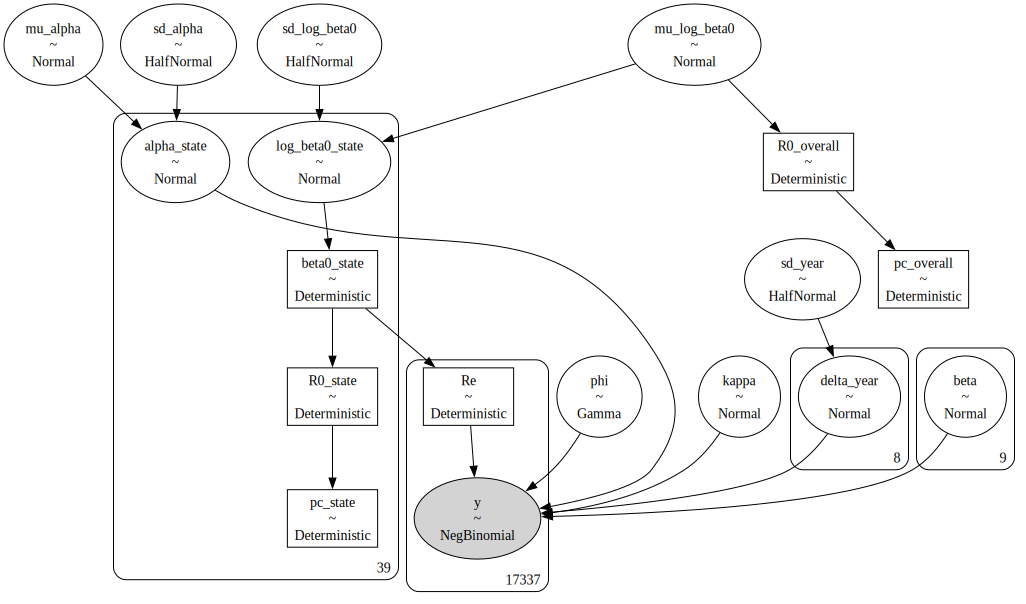

In [8]:
pm.model_to_graphviz(bhm)

In [9]:
# run in notebook (fresh kernel state)
print("N observations:", len(y_obs))
print("Covariate matrix shape:", X.shape)
print("states (S):", S, "years (T):", T)
print("Number of model free random variables:", len(bhm.free_RVs))
print("List of free RV names:", [v.name for v in bhm.free_RVs])

N observations: 17337
Covariate matrix shape: (17337, 9)
states (S): 39 years (T): 8
Number of model free random variables: 11
List of free RV names: ['mu_log_beta0', 'sd_log_beta0', 'log_beta0_state', 'mu_alpha', 'sd_alpha', 'alpha_state', 'sd_year', 'delta_year', 'beta', 'kappa', 'phi']


In [10]:
# small trial run to test sampler behavior
with bhm:
    idata_small = pm.sample(draws=200, tune=200, chains=1, cores=1, progressbar=True, random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log_beta0, sd_log_beta0, log_beta0_state, mu_alpha, sd_alpha, alpha_state, sd_year, delta_year, beta, kappa, phi]


c:\Users\ams21\anaconda3\envs\measles-threshold\lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\ams21\anaconda3\envs\measles-threshold\lib\site-packages\pytensor\scalar\basic.py:2094: RuntimeWarning: 
invalid value encountered in divide
  return x / y

c:\Users\ams21\anaconda3\envs\measles-threshold\lib\site-packages\pytensor\scalar\basic.py:2052: RuntimeWarning: 
invalid value encountered in scalar subtract
  return x - y

c:\Users\ams21\anaconda3\envs\measles-threshold\lib\site-packages\pytensor\scalar\basic.py:3023: RuntimeWarning: 
divide by zero encountered in log
  return np.log(x)

c:\Users\ams21\anaconda3\envs\measles-threshold\lib\site-packages\numpy\_core\fromnumeric.py:86: RuntimeWarning: 
invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)

c:\Users\ams21\anaconda3\envs\measles-threshold\lib\site-packages\pytensor\scalar\basic.py:2094: RuntimeWarning: 
divide by zero encountered in divide
  return x / y

c:\Users\ams21\anaconda3\envs\measles-threshold\lib\site-packages\pytensor\scalar\basic.py:1952: RuntimeWarning: 
invalid value encountered in scalar add
  return sum(inputs)

c:\Users\ams21\anaconda3\envs\measles-threshold\lib\site-packages\pytensor\scalar\basic.py:2094: RuntimeWarning: 
overflow encountered in divide
  return x / y

c:\Users\ams21\anaconda3\envs\measles-threshold\lib\site-packages\pytensor\scalar\basic.py:3191: RuntimeWarning: 
overflow encountered in exp
  return np.exp(x)

ValueError: Not enough samples to build a trace.

In [ ]:
with bhm: 
    trace1 = pm.sample(500)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_log_beta0, sd_log_beta0, log_beta0_state, mu_alpha, sd_alpha, alpha_state, sd_year, delta_year, beta, kappa, phi]


c:\Users\ams21\anaconda3\envs\measles-threshold\lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [7]:
import traceback
try:
    gv = pm.model_to_graphviz(bhm)
    print('Graphviz object:', type(gv))
    # Show DOT source (text)
    try:
        print(gv.source[:1000])  # show first 1000 chars
    except Exception as e:
        print('Could not print source:', e)
    # Try to render to bytes here
    try:
        png = gv.pipe(format='png')
        print('Rendered png bytes len:', len(png))
    except Exception as e:
        print('Render failed; traceback:')
        traceback.print_exc()
except Exception:
    print('pm.model_to_graphviz raised an exception; full traceback:')
    traceback.print_exc()

Graphviz object: <class 'graphviz.graphs.Digraph'>
digraph {
	pc_overall [label="pc_overall
~
Deterministic" shape=box]
	kappa [label="kappa
~
Normal" shape=ellipse]
	R0_overall [label="R0_overall
~
Deterministic" shape=box]
	sd_alpha [label="sd_alpha
~
HalfNormal" shape=ellipse]
	mu_alpha [label="mu_alpha
~
Normal" shape=ellipse]
	mu_log_beta0 [label="mu_log_beta0
~
Normal" shape=ellipse]
	phi [label="phi
~
Gamma" shape=ellipse]
	sd_log_beta0 [label="sd_log_beta0
~
HalfNormal" shape=ellipse]
	sd_year [label="sd_year
~
HalfNormal" shape=ellipse]
	subgraph cluster39 {
		log_beta0_state [label="log_beta0_state
~
Normal" shape=ellipse]
		pc_state [label="pc_state
~
Deterministic" shape=box]
		R0_state [label="R0_state
~
Deterministic" shape=box]
		alpha_state [label="alpha_state
~
Normal" shape=ellipse]
		beta0_state [label="beta0_state
~
Deterministic" shape=box]
		label=39 labeljust=r labelloc=b style=rounded
	}
	subgraph cluster8 {
		delta_year [label="delta_year
~
Normal" shape=ellips

Traceback (most recent call last):
  File "c:\Users\ams21\anaconda3\envs\measles-threshold\lib\site-packages\graphviz\backend\execute.py", line 88, in run_check
    proc.check_returncode()
  File "c:\Users\ams21\anaconda3\envs\measles-threshold\lib\subprocess.py", line 457, in check_returncode
    raise CalledProcessError(self.returncode, self.args, self.stdout,
subprocess.CalledProcessError: Command '[WindowsPath('dot'), '-Kdot', '-Tpng']' returned non-zero exit status 3221225477.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\ams21\AppData\Local\Temp\ipykernel_17916\216341525.py", line 12, in <module>
    png = gv.pipe(format='png')
  File "c:\Users\ams21\anaconda3\envs\measles-threshold\lib\site-packages\graphviz\piping.py", line 104, in pipe
    return self._pipe_legacy(format,
  File "c:\Users\ams21\anaconda3\envs\measles-threshold\lib\site-packages\graphviz\_tools.py", line 185, in wrapper
    return func(

Short smoke test: 

In [ ]:
with bhm: 
    idata_test = pm.sample(500, tune=500, chains=2, target_accept=0.9, progressbar=True)
az.summary(idata_test, var_names=['mu_log_beta0', 'sd_log_beta0', 'phi', 'kappa'])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log_beta0, sd_log_beta0, log_beta0_state, mu_alpha, sd_alpha, alpha_state, sd_year, delta_year, beta, kappa, phi]


c:\Users\ams21\anaconda3\envs\measles-threshold\lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')